# Experiments with WCDS
This notebook contains all experiments that are done using WCDS.

In [2]:
import matplotlib.pyplot as plt
from wcds.wcds import WCDS
from wcds.clusterers import *
from sklearn.preprocessing import minmax_scale, MinMaxScaler, LabelEncoder
from sklearn.metrics import *
from scipy.io import arff
import pandas as pd
import numpy as np
import random
import math
import time

## Datasets
In the following sections `datastream` will be the variable storing the current datastream. It uses a pandas dataframe for that. The last column contains the instance's class.

By executing one of the following cells, the chosen dataset/-stream will be loaded.

In [3]:
# Complex8
url = "http://www2.cs.uh.edu/~ml_kdd/restored/Complex&Diamond/Complex8.data"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None)
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# Complex9
url = "http://www2.cs.uh.edu/~ml_kdd/restored/Complex&Diamond/Complex9.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None)
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# D31
url = "http://cs.joensuu.fi/sipu/datasets/D31.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None, sep="\t")
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# Jain
url = "http://cs.joensuu.fi/sipu/datasets/jain.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None, sep="\t")
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# Agglomeration
url = "http://cs.joensuu.fi/sipu/datasets/Aggregation.txt"
datastream = pd.read_csv(url, names=['X', 'Y', "Class"], header=None, sep="\t")
datastream["X"] = minmax_scale(datastream["X"])
datastream["Y"] = minmax_scale(datastream["Y"])
datastream = datastream.sample(frac=1).reset_index(drop=True)

In [ ]:
# Forest Cover Type
data = arff.loadarff('../Datasets/covtypeNorm.arff')
datastream = pd.DataFrame(data[0])
labels = datastream["class"].astype(int)
datastream = datastream.select_dtypes(exclude="O")
datastream["Class"] = labels

In [ ]:
# 10% of Network Intrusion Detection (KDD Cup 1999)
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
header = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
    "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
    "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "Class"]
datastream = pd.read_csv(url, names=header, header=None)
label_encoder = LabelEncoder() 
classes = label_encoder.fit_transform(datastream['Class']) 
datastream = datastream.select_dtypes(exclude=["object"])
datastream = datastream.drop(columns=["land", "logged_in", "is_host_login", "is_guest_login"])
scaler = MinMaxScaler()
datastream = pd.DataFrame(scaler.fit_transform(datastream), columns=datastream.columns)
datastream["Class"] = classes

In [ ]:
# SEA Concepts
datastream = pd.read_csv("../Datasets/sea.data", header=None)
labels = datastream.iloc[:, 3]
datastream = datastream.drop(columns=[3])
scaler = MinMaxScaler()
datastream = pd.DataFrame(scaler.fit_transform(datastream), columns=datastream.columns)
datastream["Class"] = labels

In [ ]:
# Gas mixture dataset CO2
# TODO

In [ ]:
# Gas mixture dataset ETHYLEN
# TODO

In [ ]:
# SAM KNN DATA SETS
# TODO

Take a look at the first rows of the dataset and its description.

In [ ]:
datastream.head()

In [ ]:
datastream.describe()

## Online clustering
The next step, is to perform the online step of stream clustering with WCDS on the previous selected `datastream`.

In [4]:
%%time

# Parameters
OMEGA = math.inf
DELTA = 50
GAMMA = 200
EPSILON = 0.5
DIM = len(datastream.iloc[0])-1
µ = 1

# Clusterer instance
c_online = WCDS(
    omega=OMEGA,
    delta=DELTA,
    gamma=GAMMA,
    epsilon=EPSILON,
    dimension=DIM,
    µ=µ)

assigned_discriminators = []
number_discriminators = []
time_ = 0

for i in range(len(datastream)):
    k = c_online.record(list(datastream.iloc[i])[:-1], time_)
    number_discriminators.append(len(c_online.discriminators))
    assigned_discriminators.append(k)
    time_ += 1
    if i > 0 and i % 200 == 0:
        print("Number of discriminators: {} Cluster Measures: {}".format(len(c_online), homogeneity_completeness_v_measure(datastream["Class"][i-200:i], assigned_discriminators[i-200:i])))

Number of discriminators: 33 Cluster Measures: (0.8977685614554353, 0.48063295384046356, 0.6260834027954487)
Number of discriminators: 40 Cluster Measures: (0.9417817899995202, 0.4887742861626767, 0.6435521540168304)
Number of discriminators: 46 Cluster Measures: (0.9282749504307852, 0.45350682483039345, 0.6093278010703023)
Number of discriminators: 53 Cluster Measures: (0.932377152856411, 0.45714165505793736, 0.6134907024896642)
Number of discriminators: 55 Cluster Measures: (0.9551455380718835, 0.4844111278966982, 0.6428133582245492)
Number of discriminators: 57 Cluster Measures: (0.9478248352369664, 0.4686261586274641, 0.6271667901153254)
Number of discriminators: 59 Cluster Measures: (0.9484857065689452, 0.46907209426205504, 0.6277108086839298)
Number of discriminators: 63 Cluster Measures: (0.9285219739233599, 0.44559712807081564, 0.6021992188747662)
Number of discriminators: 65 Cluster Measures: (0.9442929300537455, 0.46567145629392165, 0.6237466253246965)
Number of discriminator

In [ ]:
# Optional save
c_online.save()

## Offline clustering
Now we perform offline clustering on the current configuration of WCDS.

In [4]:
N_CLUSTERS = 8
THRESHOLD = None

In [5]:
%%time
# MergeClustering

c_offline = MergeClustering(n_clusters=N_CLUSTERS, distance_threshold=THRESHOLD)
actual_clusters1 = c_offline.fit(c_online.discriminators)

Wall time: 937 ms


In [6]:
%%time
# MinDistanceClustering

c_offline = MinDistanceClustering(n_clusters=N_CLUSTERS, distance_threshold=THRESHOLD)
actual_clusters2 = c_offline.fit(c_online.discriminators)

Wall time: 477 ms


In [7]:
%%time
# CentroidClustering

c_offline = CentroidClustering(n_clusters=N_CLUSTERS, distance_threshold=THRESHOLD)
centroids = [c_online.centroid(d) for d in c_online.discriminators.values()]
actual_clusters3 = c_offline.fit(c_online.discriminators, centroids)

Wall time: 96.7 ms


## Plot results and evaluate clustering

In [8]:
# Initialize color list
number_of_colors = len(c_online.discriminators)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]
color_dict = {key: value for (key, value) in enumerate(colors)}

In [9]:
def return_correct(index, clustering):
    # Returns correct offline cluster for given discriminator
    for i in range(len(clustering)):
        if index in clustering[i]:
            return i

In [10]:
# DRASiW
drasiw = []
for d in c_online.discriminators.values():
    drasiw.extend(d.drasiw(c_online.seed, c_online.dimension, c_online.gamma))

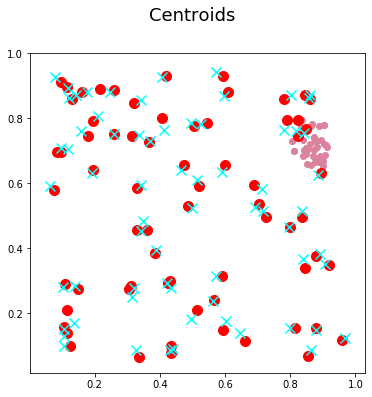

In [11]:
# Plot centroids
%matplotlib inline

c_id=0

plt.figure(5, figsize=(6,6))
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    if k == c_id:
        plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[int(k)])
plt.scatter([d[0] for d in drasiw], [d[1] for d in drasiw], marker="o", s=100, color="red")
plt.scatter([centroid[0] for centroid in centroids], [centroid[1] for centroid in centroids], marker="x", s=100, color="cyan")
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('Centroids', fontsize=18)
plt.show()

In [13]:
# Plot discriminator epsilon areas
def plot_epsilon_areas(discr_ids):
    # Plotting
    step = 0.01
    points = []

    for i in np.arange(0, 1, step):
        for j in np.arange(0, 1, step):
            discr = max([(id_, c_online.discriminators[id_].matching(
                c_online.addressing((i, j)))) for id_ in discr_ids], key=lambda x: x[1])
            c = color_dict[discr[0]]
            if discr[1] > c_online.epsilon:
                points.append(((i, j), c))
    plt.scatter([point[0][0] for point in points],
                          [point[0][1] for point in points],
                          marker="s",
                          s=1.5,
                          c=[point[1] for point in points])
    plt.axis('scaled', xlim=[0, 1, 0, 1])
    plt.show()

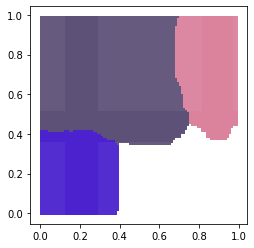

In [15]:
plot_epsilon_areas([0,1,2])

Found 67 Microclusters and formed 8, 8, 8 Clusters.


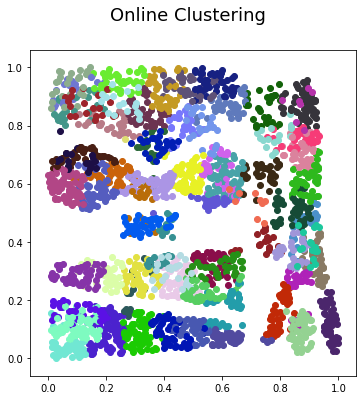

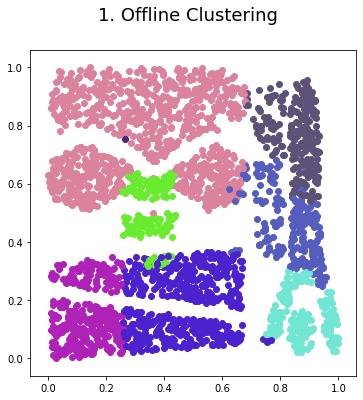

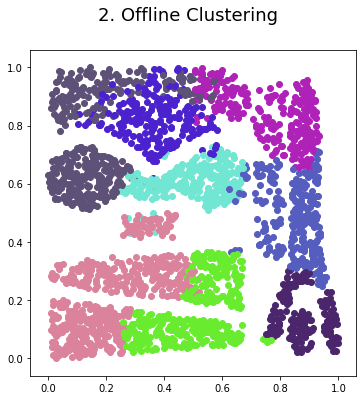

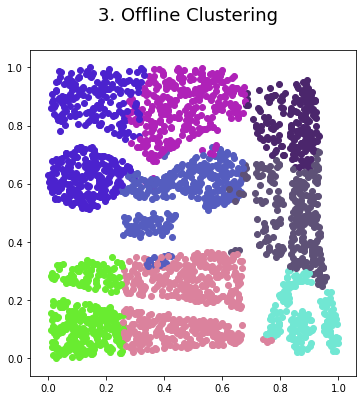

In [16]:
# Plot results of online vs offline clustering
%matplotlib inline

# Online
plt.figure(1, figsize=(6,6))
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[int(k)])
    plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('Online Clustering', fontsize=18)
    
# Offline1
plt.figure(2, figsize=(6,6))        
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    correct = return_correct(k, actual_clusters1)
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[correct])
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('1. Offline Clustering', fontsize=18)

# Offline2
plt.figure(3, figsize=(6,6))        
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    correct = return_correct(k, actual_clusters2)
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[correct])
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('2. Offline Clustering', fontsize=18)

# Offline3
plt.figure(4, figsize=(6,6))        
for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    correct = return_correct(k, actual_clusters3)
    plt.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[correct])
plt.axis('scaled', xlim=[0, 1, 0, 1])
plt.suptitle('3. Offline Clustering', fontsize=18)
    
print("Found {} Microclusters and formed {}, {}, {} Clusters.".format(len(c_online.discriminators), len(actual_clusters1), len(actual_clusters2), len(actual_clusters3)))
plt.show()

In [17]:
# Calculate Homogeneity, Completeness, V-Measure of clusterings
print("Homogeneity, Completeness, V-Measure")

# Online
print("Online: ", homogeneity_completeness_v_measure(datastream["Class"], assigned_discriminators))

# Offline
print("Offline1: ", homogeneity_completeness_v_measure(datastream["Class"], [return_correct(assigned_discriminators[i], actual_clusters1) for i in range(len(assigned_discriminators))]))
print("Offline2: ", homogeneity_completeness_v_measure(datastream["Class"], [return_correct(assigned_discriminators[i], actual_clusters2) for i in range(len(assigned_discriminators))]))
print("Offline3: ", homogeneity_completeness_v_measure(datastream["Class"], [return_correct(assigned_discriminators[i], actual_clusters3) for i in range(len(assigned_discriminators))]))

Homogeneity, Completeness, V-Measure
Online:  (0.9356448540316971, 0.424292698344321, 0.5838316312620235)
Offline1:  (0.6201088766757306, 0.6617581993415408, 0.6402569210212058)
Offline2:  (0.6336754216437104, 0.5807654953213547, 0.6060678868488162)
Offline3:  (0.6653676756251427, 0.6102786345031979, 0.6366336394329017)


The following cell visualizes the behavior of the online clustering over time. 

In [ ]:
# Live online clustering plot
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.ion()
ax.axis('scaled', xlim=[0, 1, 0, 1])
fig.show()
fig.canvas.draw()

for i in range(len(assigned_discriminators)):
    k = assigned_discriminators[i]
    ax.scatter(datastream["X"][i], datastream["Y"][i], marker="o", color=color_dict[int(k)])
    fig.canvas.draw()

## Results

Gamma: Resolution of binary encoding; unterteilt jede dimension in gamma subräume/abschnitte
Je höher, desto kleiner die epsilon area.

Delta: Bestimmt anzahl der Neuronen; Gibt an wie viele verschiedene Epsilonzonen es gibt (ohne 0%)
Je höher, desto größer die epsilon area.

Area gelichbeliben bei gelichem gamm delta verhältnis?!